# Standalone Convergence Checker for the numerical KdV solver

Does not save or require any input data

In [140]:
import xarray as xr
from iwaves.kdv.kdvimex import KdVImEx#from_netcdf
from iwaves.kdv.solve import solve_kdv

import numpy as np
from scipy.interpolate import PchipInterpolator as pchip
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import rcParams

# Set font sizes
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

In [58]:
# Functions

def fullsine(x, a_0, L_w, x0=0.):
    
    k = 2*np.pi/L_w
    eta =  - a_0 * np.cos(k*x + k*x0 + np.pi/2)
    eta[x>x0+1*L_w/2] = 0.
    #eta[x<x0-4*L_w/2] = 0.
    eta[x<x0-L_w/2] = 0.

    return eta

def double_tanh(beta, z):
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
        + np.tanh((z+beta[4])/beta[5]))


def run_kdv(args):
    """
    Main function for generating different soliton scenarios
    """
    rho_params, a0, L_d, mode, nu_H, dx, runtime, dt = args
    ####################################################
    # Inputs
    mode = 0
    
    Nz = 100

    # Depth
    d = 252.5

    ntout = 1800.0

    z = np.linspace(0, -d, Nz)

    dz = np.abs(z[1]-z[0])
    
    x = np.arange(-2*dx,L_d+dx,dx)

    kdvargs = dict(\
        verbose=False,\
        a0=a0,\
        Lw=5e4,\
        mode=mode,
        dt=dt,\
        nu_H=nu_H,\
        ekdv=False,\
        wavefunc=fullsine,\
        #L_d = L_d,
        x=x,
    )

    ii=0
    #rhoz = single_tanh_rho(
    #        z, pp['rho0'][ii], pp['drho1'][ii], pp['z1'][ii], pp['h1'][ii])
    rhoz = double_tanh(rho_params,z)
    ######
    #
    ## Test initialising the kdv class
    iw = KdVImEx(rhoz, z, **kdvargs)
    iw.print_params()

    # Update the wavelength to represent an internal tide
    omega = 2*np.pi/(12.42*3600)
    k = omega/iw.c1
    Lw = 2*np.pi/k
    kdvargs['Lw'] = Lw
    #mykdv0.Lw = Lw
    print('Lw =',Lw)

    # Need to reinit
    mykdv = KdVImEx(rhoz, z, **kdvargs)


    ## Call the KdV run function
    mykdv, Bda = solve_kdv(rhoz, z, runtime,\
            ntout=ntout, outfile=None, **kdvargs)

    
    return mykdv, Bda

In [125]:
#betas = [1023.7, 1.12, 105, 52, 155, 43] # ~April 5
#betas = [1023.5, 1.22, 67, 55, 157, 52] # ~March 1

betas_w = [1023.8229810318612,
     0.9865506702797462,
     143.5428700089361,
     46.1265812512485,
     136.66278860120943,
     41.57014327398592] # 15 July 2016

betas_s =[1023.6834358117951,
     1.2249066117658955,
     156.78804559089772,
     53.66835548728355,
     73.14183287436342,
     40.21031777315428] # 1st April 2017

a0 = 35.
L_d = 2.0e5
mode =0
nu_H = 0
runtime = 1.25*86400.

dxs =[1600,800,400,200,100,75,50,37.5,25]
dt = 10.

all_kdv_dx_w = []
all_kdv_dx_s = []

for dx in dxs:
    print(dx)
    mykdv, B = run_kdv( (betas_w, a0, L_d, mode, nu_H, dx, runtime, dt))
    all_kdv_dx_w.append(mykdv)
    
    mykdv, B = run_kdv( (betas_s, a0, L_d, mode, nu_H, dx, runtime, dt))
    all_kdv_dx_s.append(mykdv)


1600
Parameters:
 c1 = 1.284269
 epsilon = 1.000000
 mu = 1.000000
 r01 = -3996.877504
 r10 = -0.001141
 r20 = 0.0000356

Lw = 57422.22378512493
Parameters:
 c1 = 1.254718
 epsilon = 1.000000
 mu = 1.000000
 r01 = -4012.062225
 r10 = 0.001299
 r20 = 0.0000151

Lw = 56100.93471309257
800
Parameters:
 c1 = 1.284269
 epsilon = 1.000000
 mu = 1.000000
 r01 = -3996.877504
 r10 = -0.001141
 r20 = 0.0000356

Lw = 57422.22378512493
Parameters:
 c1 = 1.254718
 epsilon = 1.000000
 mu = 1.000000
 r01 = -4012.062225
 r10 = 0.001299
 r20 = 0.0000151

Lw = 56100.93471309257
400
Parameters:
 c1 = 1.284269
 epsilon = 1.000000
 mu = 1.000000
 r01 = -3996.877504
 r10 = -0.001141
 r20 = 0.0000356

Lw = 57422.22378512493
Parameters:
 c1 = 1.254718
 epsilon = 1.000000
 mu = 1.000000
 r01 = -4012.062225
 r10 = 0.001299
 r20 = 0.0000151

Lw = 56100.93471309257
200
Parameters:
 c1 = 1.284269
 epsilon = 1.000000
 mu = 1.000000
 r01 = -3996.877504
 r10 = -0.001141
 r20 = 0.0000356

Lw = 57422.22378512493
Parame

<IPython.core.display.Javascript object>


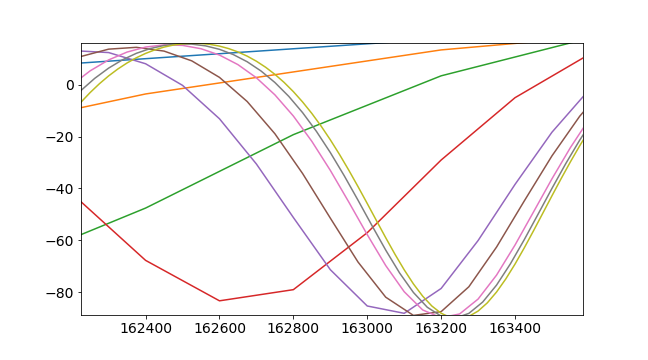

In [126]:
plt.figure(figsize=(9,5))
for mykdv in all_kdv_dx_s:
    plt.plot(mykdv.x, mykdv.B)

<IPython.core.display.Javascript object>


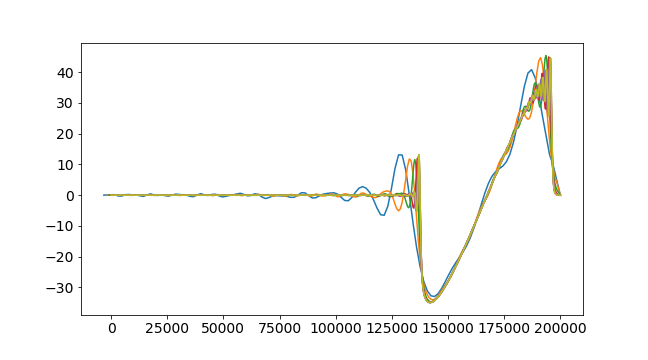

In [127]:
plt.figure(figsize=(9,5))
for mykdv in all_kdv_dx_w:
    plt.plot(mykdv.x, mykdv.B)

In [130]:
# Compute the errors
X = np.arange(0,L_d, 10.)
nx = X.shape[0]
ndx = len(dxs)

solns = np.zeros((ndx, nx))
for ii, mykdv in enumerate(all_kdv_dx_w):
    Fx = pchip(mykdv.x, mykdv.B)
    solns[ii,:] = Fx(X)

# Compute the error between each solution
#err = np.diff(solns, axis=0)
err = solns - solns[-1,:]

err_rms_w = np.linalg.norm(err, ord=2, axis=1) # L2-norm
#err_rms_w = np.sqrt(np.mean(err**2,axis=1))

solns = np.zeros((ndx, nx))
for ii, mykdv in enumerate(all_kdv_dx_s):
    Fx = pchip(mykdv.x, mykdv.B)
    solns[ii,:] = Fx(X)

# Compute the error between each solution
#err = np.diff(solns, axis=0)
err = solns - solns[-1,:]

err_rms_s = np.linalg.norm(err, ord=2, axis=1) # L2-norm
#err_rms_s = np.sqrt(np.mean(err**2,axis=1))



<IPython.core.display.Javascript object>


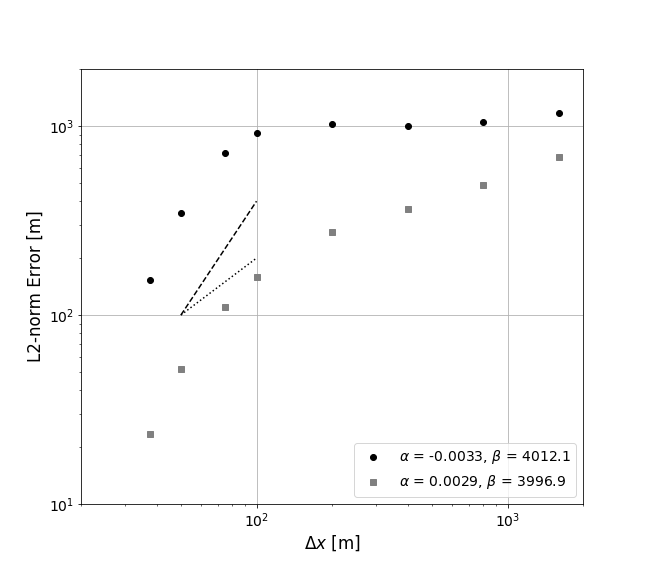

In [131]:
plt.figure(figsize=(9,8))
plt.loglog(dxs[:-1],err_rms_s[:-1],'ko')
plt.loglog(dxs[:-1],err_rms_w[:-1],'s', color='0.5')
plt.xlim(2e1,2e3)
plt.ylim(1e1,2e3)
plt.grid(b=True)
x0 = np.array([50,100.])
plt.plot(x0, 100/x0[0]**2*x0**2, 'k--')
plt.plot(x0, 100/x0[0]**1*x0**1, 'k:')
plt.ylabel('L2-norm Error [m]')
plt.xlabel('$\Delta x$ [m]')

alpha_s = -2*all_kdv_dx_s[0].c1*all_kdv_dx_s[0].r10 
beta_s = -1*all_kdv_dx_s[0].r01
alpha_w = -2*all_kdv_dx_w[0].c1*all_kdv_dx_w[0].r10 
beta_w = -1*all_kdv_dx_w[0].r01
plt.legend((r'$\alpha$ = %3.4f, $\beta$ = %3.1f'%(alpha_s,beta_s),
           r'$\alpha$ = %3.4f, $\beta$ = %3.1f'%(alpha_w,beta_w) ), loc='lower right')

In [115]:
# Delta t comparison
dts = [20,10.,5,2.5,1.25]
dx = 50.

all_kdv_dt_w = []
all_kdv_dt_s = []

for dt in dts:
    print(dt)
    mykdv, B = run_kdv( (betas_w, a0, L_d, mode, nu_H, dx, runtime, dt))
    all_kdv_dt_w.append(mykdv)
    
    mykdv, B = run_kdv( (betas_s, a0, L_d, mode, nu_H, dx, runtime, dt))
    all_kdv_dt_s.append(mykdv)


20
Parameters:
 c1 = 1.284269
 epsilon = 1.000000
 mu = 1.000000
 r01 = -3996.877504
 r10 = -0.001141
 r20 = 0.0000356

Lw = 57422.22378512493


/home/suntans/code/iwaves/iwaves/kdv/solve.py:97: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  ds.merge( xray.Dataset({'B_t':Bda}), inplace=True )


Parameters:
 c1 = 1.254718
 epsilon = 1.000000
 mu = 1.000000
 r01 = -4012.062225
 r10 = 0.001299
 r20 = 0.0000151

Lw = 56100.93471309257
10.0
Parameters:
 c1 = 1.284269
 epsilon = 1.000000
 mu = 1.000000
 r01 = -3996.877504
 r10 = -0.001141
 r20 = 0.0000356

Lw = 57422.22378512493
Parameters:
 c1 = 1.254718
 epsilon = 1.000000
 mu = 1.000000
 r01 = -4012.062225
 r10 = 0.001299
 r20 = 0.0000151

Lw = 56100.93471309257
5
Parameters:
 c1 = 1.284269
 epsilon = 1.000000
 mu = 1.000000
 r01 = -3996.877504
 r10 = -0.001141
 r20 = 0.0000356

Lw = 57422.22378512493
Parameters:
 c1 = 1.254718
 epsilon = 1.000000
 mu = 1.000000
 r01 = -4012.062225
 r10 = 0.001299
 r20 = 0.0000151

Lw = 56100.93471309257
2.5
Parameters:
 c1 = 1.284269
 epsilon = 1.000000
 mu = 1.000000
 r01 = -3996.877504
 r10 = -0.001141
 r20 = 0.0000356

Lw = 57422.22378512493
Parameters:
 c1 = 1.254718
 epsilon = 1.000000
 mu = 1.000000
 r01 = -4012.062225
 r10 = 0.001299
 r20 = 0.0000151

Lw = 56100.93471309257
1.25
Paramete

In [132]:
# Compute the errors
X = np.arange(0,L_d, 10.)
nx = X.shape[0]
ndx = len(dts)

solns = np.zeros((ndx, nx))
for ii, mykdv in enumerate(all_kdv_dt_w):
    print(ii)
    Fx = pchip(mykdv.x, mykdv.B)
    solns[ii,:] = Fx(X)

# Compute the error between each solution
#err = np.diff(solns, axis=0)
err = solns - solns[-1,:]

err_rms_w_t = np.linalg.norm(err, ord=2, axis=1) # L2-norm
#err_rms_w = np.sqrt(np.mean(err**2,axis=1))

solns = np.zeros((ndx, nx))
for ii, mykdv in enumerate(all_kdv_dt_s):
    print(ii)
    Fx = pchip(mykdv.x, mykdv.B)
    solns[ii,:] = Fx(X)

# Compute the error between each solution
#err = np.diff(solns, axis=0)
err = solns - solns[-1,:]

err_rms_s_t = np.linalg.norm(err, ord=2, axis=1) # L2-norm
#err_rms_s = np.sqrt(np.mean(err**2,axis=1))

0
1
2
3
4
0
1
2
3
4


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


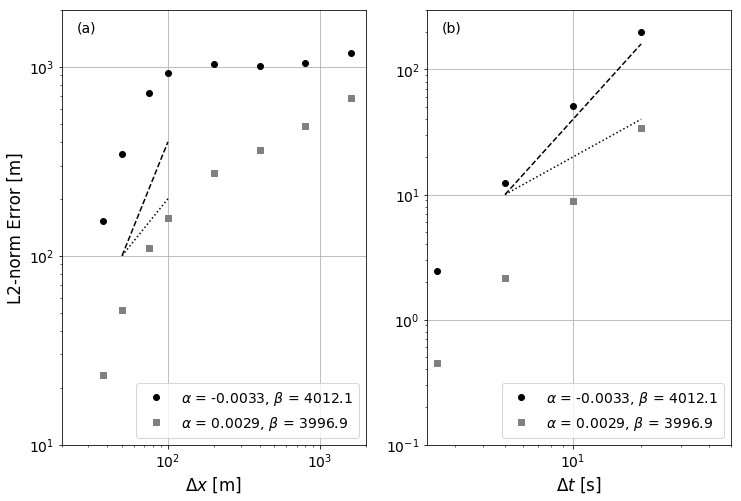

In [143]:
plt.figure(figsize=(12,8))
ax=plt.subplot(121)
plt.loglog(dxs[:-1],err_rms_s[:-1],'ko')
plt.loglog(dxs[:-1],err_rms_w[:-1],'s', color='0.5')
plt.xlim(2e1,2e3)
plt.ylim(1e1,2e3)
plt.grid(b=True)
x0 = np.array([50,100.])
plt.plot(x0, 100/x0[0]**2*x0**2, 'k--')
plt.plot(x0, 100/x0[0]**1*x0**1, 'k:')
plt.ylabel('L2-norm Error [m]')
plt.xlabel('$\Delta x$ [m]')

alpha_s = -2*all_kdv_dx_s[0].c1*all_kdv_dx_s[0].r10 
beta_s = -1*all_kdv_dx_s[0].r01
alpha_w = -2*all_kdv_dx_w[0].c1*all_kdv_dx_w[0].r10 
beta_w = -1*all_kdv_dx_w[0].r01
plt.legend((r'$\alpha$ = %3.4f, $\beta$ = %3.1f'%(alpha_s,beta_s),
           r'$\alpha$ = %3.4f, $\beta$ = %3.1f'%(alpha_w,beta_w) ), loc='lower right')
plt.text(0.05,0.95,'(a)',transform=ax.transAxes)


ax=plt.subplot(122)
plt.loglog(dts[:-1],err_rms_s_t[:-1],'ko')
plt.loglog(dts[:-1],err_rms_w_t[:-1],'s', color='0.5')
plt.xlim(0,0.5e2)
plt.ylim(1e-1,3e2)
plt.grid(b=True)
x0 = np.array([5,20])
plt.plot(x0, 10/x0[0]**2*x0**2, 'k--')
plt.plot(x0, 10/x0[0]**1*x0**1, 'k:')
#plt.ylabel('L2-norm Error [m]')
plt.xlabel('$\Delta t$ [s]')

plt.text(0.05,0.95,'(b)',transform=ax.transAxes)
alpha_s = -2*all_kdv_dt_s[0].c1*all_kdv_dt_s[0].r10 
beta_s = -1*all_kdv_dt_s[0].r01
alpha_w = -2*all_kdv_dt_w[0].c1*all_kdv_dt_w[0].r10 
beta_w = -1*all_kdv_dt_w[0].r01
plt.legend((r'$\alpha$ = %3.4f, $\beta$ = %3.1f'%(alpha_s,beta_s),
           r'$\alpha$ = %3.4f, $\beta$ = %3.1f'%(alpha_w,beta_w) ), loc='lower right')

plt.savefig('../FIGURES/kdv_convergence_dxdt.png',dpi=150)
plt.savefig('../FIGURES/kdv_convergence_dxdt.pdf',dpi=150)

In [137]:
plt.text?